In [1]:
import numpy as np
from numpy.typing import ArrayLike
import matplotlib.pyplot as plt
from typing import Callable
from my_SSIF_functions import *
import time

In [2]:
start_time = time.time()

# relevant time scale -- minutes (min)
# relevant space scale -- micrometers (mum)

# Model parameters
v0 = 4  # mum/min (estimated) --> motor velocity without load
f0 = 5  # pN (Valentine et al. 2006) --> stall force of sliding motors
mu_KC = 30  # pN*min/mum (estimated) --> friction coefficient of kinetochore-kMT interaction
mu_c = 1  # --> friction coefficient of single crosslinker
n_c = 1  # only product of n_c*mu_c is relevant, 1 pN*min/mum^2 (estimated) --> linear density of crosslinkers
n_m = 10  # mum^-1 (estimated) --> linear density of motors
d = 1  # mum (measured) --> interkinetochore distance
L0 = 14  # mum (measured) --> spindle length
D0 = 6  # mum (measured) --> bMT antiparallel overlap length

parameters = (v0, f0, mu_KC, mu_c, n_c, n_m, d, L0, D0)  # pack the parameters in a tuple for conveniency

# mum = micrometer


In [3]:
# Apply finite difference method for integrating kinetochore velocity
t = np.linspace(0, 10, 1000)  # in minutes, time points in which to calculate v_KC and x_KC

x0 = -2.5  # left kinetochore initial position
x_KC_minus = finite_difference(calculate_v_KC, t, x0, parameters)
x_KC_plus = x_KC_minus + d

x_bMT_plus = finite_difference(lambda x: 0.5*v0, t, 0)
x_bMT_minus = finite_difference(lambda x: -0.5*v0, t, 0)

# Calculate k-fiber element position vs time using finite difference method
# Cannot use finite_difference funtion because v_kMT depends on x_KC and not x_kMT
x_kMT_plus = np.zeros(t.size)
x_kMT_minus = np.zeros(t.size)
x_kMT_plus[0] = x_KC_plus[0]  # set initial position of right k-fiber element you want to track over time
x_kMT_minus[0] = x_KC_minus[0]

for i in range(1, t.size):
    x_kMT_plus[i] = x_kMT_plus[i-1] + calculate_v_kMT_plus(*parameters, x_KC_plus[i-1]) * (t[i] - t[i-1])
    x_kMT_minus[i] = x_kMT_minus[i-1] + calculate_v_kMT_minus(*parameters, x_KC_minus[i-1]) * (t[i] - t[i-1])

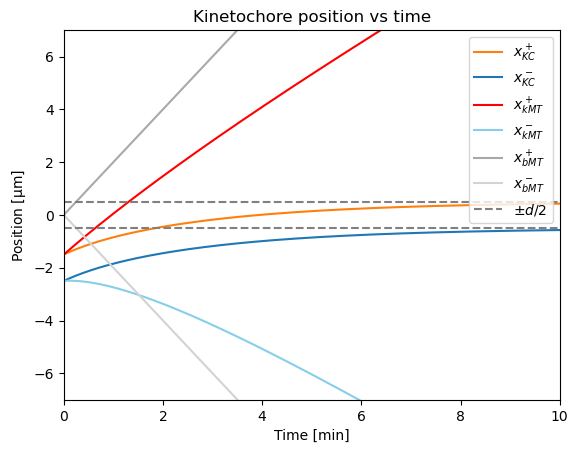

In [4]:
# Plot kinetochore position as a function of time

fig1, ax1 = plt.subplots(1, 1)
ax1.plot(t, x_KC_plus, c="C1", label="$x_{KC}^+$")
ax1.plot(t, x_KC_minus, c="C0", label="$x_{KC}^-$")
ax1.plot(t, x_kMT_plus, c="red", label="$x_{kMT}^+$")
ax1.plot(t, x_kMT_minus, c="skyblue", label="$x_{kMT}^-$")
ax1.plot(t, x_bMT_plus, c="darkgray", label="$x_{bMT}^+$")
ax1.plot(t, x_bMT_minus, c="lightgrey", label="$x_{bMT}^-$")
ax1.axhline(-d/2, c="gray", ls="--", label=r"$\pm d/2$")
ax1.axhline(d/2, c="gray", ls="--")
ax1.set_xlim(t[0], t[-1])
ax1.set_ylim(-L0/2, L0/2)
ax1.set_title("Kinetochore position vs time")
ax1.set_xlabel("Time [min]")
ax1.set_ylabel(r"Position $[\mathrm{\mu m}]$")
plt.legend()

plt.show()

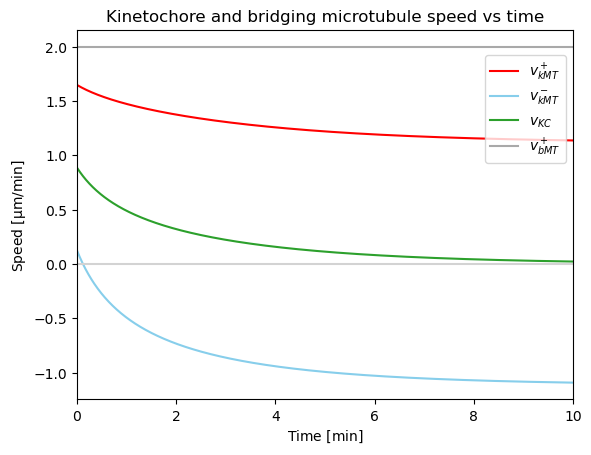

In [5]:
# Calculate and plot k-fiber velocity and kinetochore velocity

v_kMT_minus = calculate_v_kMT_minus(*parameters, x_KC_minus)
v_kMT_plus = calculate_v_kMT_plus(*parameters, x_KC_plus)
#x_KC_plus_derivative = calculate_forward_derivative(t, x_KC_plus)
#x_KC_minus_derivative = calculate_forward_derivative(t, x_KC_minus)
v_KC = calculate_v_KC(*parameters, x_KC_minus)
kMT_plus_growth = v_kMT_plus - v_KC
kMT_minus_growth = v_KC - v_kMT_minus

fig2, ax2 = plt.subplots(1, 1)
ax2.plot(t, v_kMT_plus, c="red", label="$v_{kMT}^+$")
ax2.plot(t, v_kMT_minus, c="skyblue", label="$v_{kMT}^-$")
ax2.plot(t, v_KC, c="C2", ls="-", label=r"$v_{KC}$")
ax2.axhline(v0/2, c="darkgray", label="$v_{bMT}^+$")
ax2.axhline(0, c="lightgray", ls="-")
ax2.set_xlim(t[0], t[-1])
ax2.set_title("Kinetochore and bridging microtubule speed vs time")
ax2.set_xlabel(r"Time $[\text{min}]$")
ax2.set_ylabel(r"Speed [$\mathrm{\mu}$m/min]")
ax2.legend(loc="upper right", bbox_to_anchor=(1, 0.95))

plt.show()

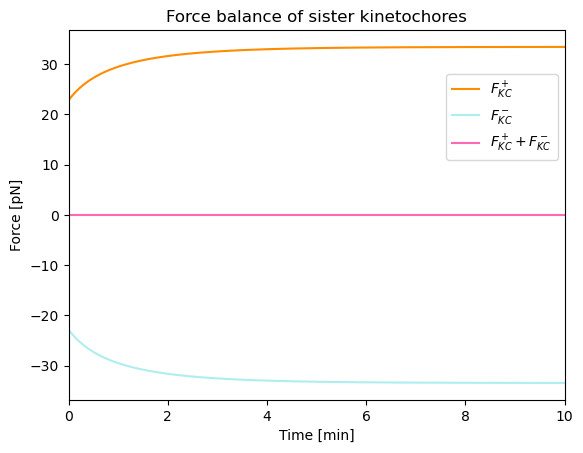

In [6]:
# Check consistency of sister kinetochore force balance
k = 100  # pN/mum --> effective interkinetochore spring constant, unused
F_KC_plus = -mu_KC * (v_KC - v_kMT_plus)  # force on right kinetochore by right k-fiber
F_KC_minus = -mu_KC * (v_KC - v_kMT_minus)  # force on left kinetochore by left k-fiber

fig3, ax3 = plt.subplots(1, 1)
ax3.plot(t, F_KC_plus, c="darkorange", label="$F_{KC}^+$")
ax3.plot(t, F_KC_minus, c="paleturquoise", label="$F_{KC}^-$")
ax3.plot(t, F_KC_plus+F_KC_minus, c="hotpink", label="$F_{KC}^+ + F_{KC}^-$")
ax3.set_xlim(t[0], t[-1])
ax3.set_xlabel("Time [min]")
ax3.set_ylabel("Force [pN]")
ax3.set_title("Force balance of sister kinetochores")
ax3.legend(loc="upper right", bbox_to_anchor=(1, 0.9))

plt.show()

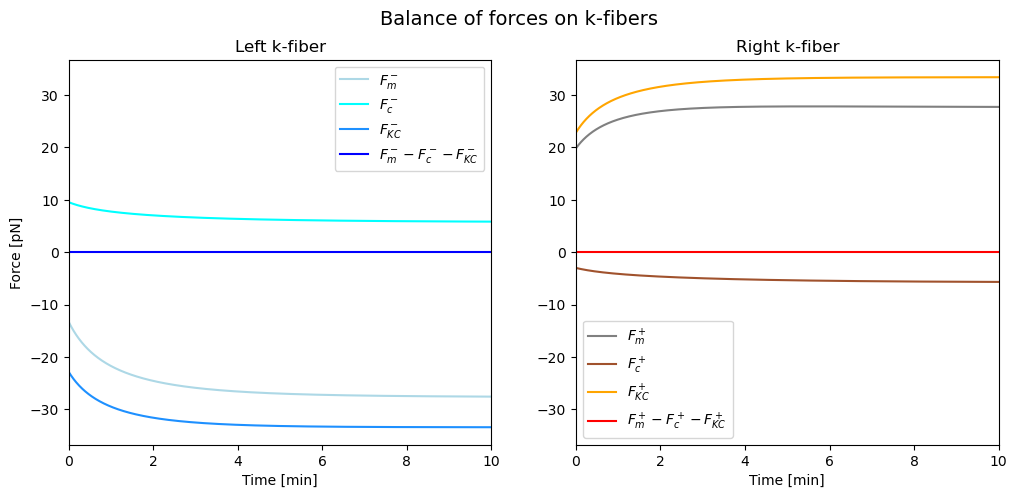

In [7]:
# Check consistency of kMT force balance (Equation 5)
D_plus = (D0/2 - x_KC_plus) * np.heaviside(D0/2 - x_KC_plus, 0)
D_minus = (D0/2 + x_KC_minus) * np.heaviside(D0/2 + x_KC_minus, 0)
F_m_plus = D_plus * n_m * f0 * (1 - (v_kMT_plus - (-v0/2))/v0)  # force of motors on right k-fiber
F_m_minus = D_minus * n_m * f0 * (-1 - (v_kMT_minus - v0/2)/v0)

L_plus = L0/2 - x_KC_plus
L_minus = L0/2 + x_KC_minus
F_c_plus = n_c * L_plus * mu_c * (v_kMT_plus - v0/2)  # force of crosslinkers on right bridging fiber
F_c_minus = n_c * L_minus * mu_c * (v_kMT_minus - (-v0/2))

fig4, ax4 = plt.subplots(1, 2, figsize=(12,5), sharey=True)
ax4[0].plot(t, F_m_minus, c="lightblue", label="$F_m^-$")
ax4[0].plot(t, F_c_minus, c="cyan", label="$F_c^-$")
ax4[0].plot(t, F_KC_minus, c="dodgerblue", label="$F_{KC}^-$")
ax4[0].plot(t, F_m_minus - F_c_minus - F_KC_minus, c="blue", label="$F_m^- - F_c^- - F_{KC}^-$")
ax4[0].set_xlim(t[0], t[-1])
ax4[0].set_xlabel("Time [min]")
ax4[0].set_ylabel("Force [pN]")
ax4[0].set_title("Left k-fiber")
ax4[0].legend()

ax4[1].plot(t, F_m_plus, c="gray", label="$F_m^+$")
ax4[1].plot(t, F_c_plus, c="sienna", label="$F_c^+$")
ax4[1].plot(t, F_KC_plus, c="orange", label="$F_{KC}^+$")
ax4[1].plot(t, F_m_plus - F_c_plus - F_KC_plus, c="red", label="$F_m^+ - F_c^+ - F_{KC}^+$")
ax4[1].set_xlim(t[0], t[-1])
ax4[1].set_xlabel("Time [min]")
#ax4[1].set_ylabel("Force [pN]")
ax4[1].set_title("Right k-fiber")
ax4[1].tick_params(labelleft=True)
ax4[1].legend()
fig4.suptitle("Balance of forces on k-fibers", fontsize=14)

plt.show()


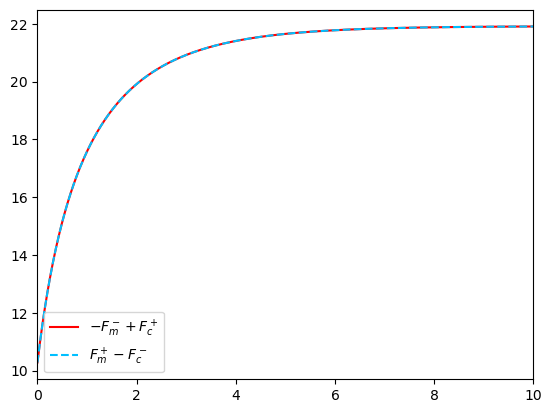

In [8]:
# Check consistency of bMT force balance (Equation 6)
# F_bMT = 0 in case v_bMT_plus = v0/2 and v_bMT_minus = -v0/2

# ne smijem staviti da je F_bMT = 0 jer ova jednadžba vrijedi prije aproksimacije v_bMT = +-v0/2

fig5, ax5 = plt.subplots(1, 1)
ax5.plot(t, -F_m_minus+F_c_plus, c="red", ls="-", label="$-F_m^- + F_c^+$")
ax5.plot(t, F_m_plus-F_c_minus, c="deepskyblue", ls="--", label="$F_m^+ - F_c^-$")
ax5.set_xlim(t[0], t[-1])
ax5.legend()

plt.show()

In [9]:
print(f"Time taken: {time.time()-start_time:.2f}")

Time taken: 2.75


In [10]:
start_time = time.time()

# relevant time scale -- minutes (min)
# relevant space scale -- micrometers (mum)

# Model parameters
v0 = 4  # mum/min (estimated) --> motor velocity without load
f0 = 5  # pN (Valentine et al. 2006) --> stall force of sliding motors
mu_KC = 30  # pN*min/mum (estimated) --> friction coefficient of kinetochore-kMT interaction
mu_c = 1  # --> friction coefficient of single crosslinker
L0 = 14  # mum (measured) --> spindle length
D0 = 6  # mum (measured) --> bMT antiparallel overlap length
d = 1  # mum (measured) --> interkinetochore distance

n_c = np.linspace(1, 100, 3)  # only product of n_c*mu_c is relevant, 1 pN*min/mum^2 (estimated) --> linear density of crosslinkers
n_m = np.linspace(0.1, 10, 2)  # mum^-1 (estimated) --> linear density of motors

# mum = micrometer

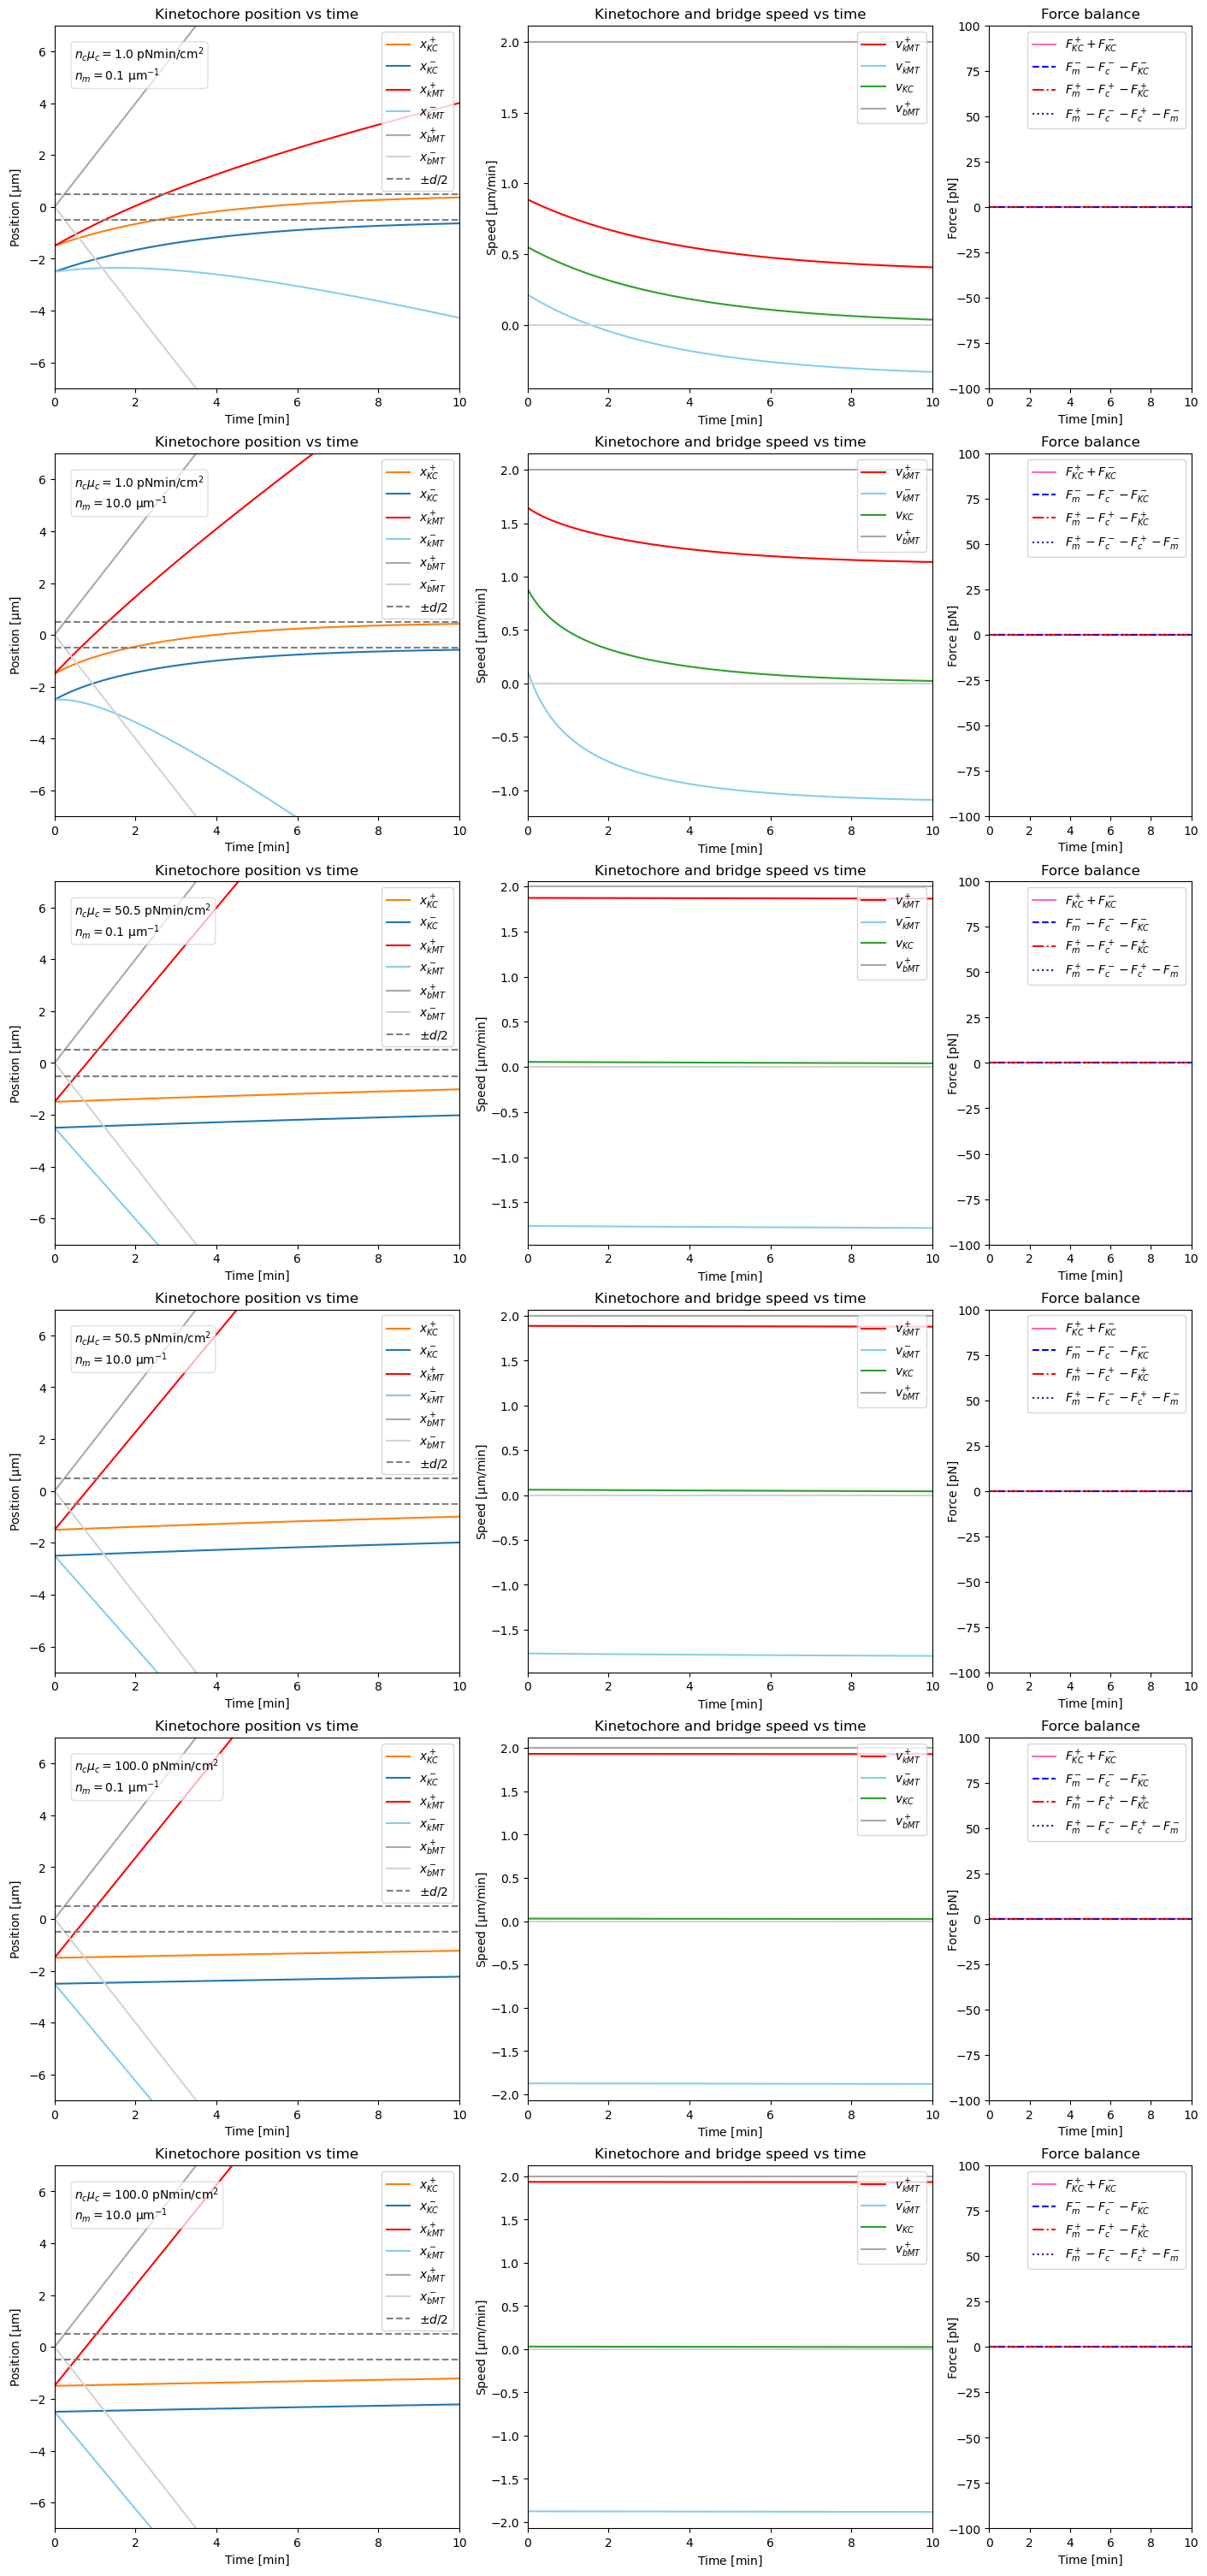

In [11]:
lennm = len(n_m)
lennc = len(n_c)
fig, ax = plt.subplots(lennc*lennm, 3, figsize=(14, 5*lennc*lennm), width_ratios=[2, 2, 1], layout="constrained")

t = np.linspace(0, 10, 1000)  # in minutes, time points in which to calculate v_KC and x_KC

for i in range(lennc):
    for j in range(lennm):
        parameters = (v0, f0, mu_KC, mu_c, n_c[i], n_m[j], d, L0, D0)

        # Apply finite difference method for integrating kinetochore velocity
        
        x0 = -2.5  # left kinetochore initial position
        x_KC_minus = finite_difference(calculate_v_KC, t, x0, parameters)
        x_KC_plus = x_KC_minus + d
        
        x_bMT_plus = finite_difference(lambda x: 0.5*v0, t, 0)
        x_bMT_minus = finite_difference(lambda x: -0.5*v0, t, 0)
        
        # Calculate k-fiber element position vs time using finite difference method
        # Cannot use finite_difference funtion because v_kMT depends on x_KC and not x_kMT
        x_kMT_plus = np.zeros(t.size)
        x_kMT_minus = np.zeros(t.size)
        x_kMT_plus[0] = x_KC_plus[0]  # set initial position of right k-fiber element you want to track over time
        x_kMT_minus[0] = x_KC_minus[0]
        
        for k in range(1, t.size):
            x_kMT_plus[k] = x_kMT_plus[k-1] + calculate_v_kMT_plus(*parameters, x_KC_plus[k-1]) * (t[k] - t[k-1])
            x_kMT_minus[k] = x_kMT_minus[k-1] + calculate_v_kMT_minus(*parameters, x_KC_minus[k-1]) * (t[k] - t[k-1])


        # Calculate and plot k-fiber velocity and kinetochore velocity

        v_kMT_minus = calculate_v_kMT_minus(*parameters, x_KC_minus)
        v_kMT_plus = calculate_v_kMT_plus(*parameters, x_KC_plus)
        #x_KC_plus_derivative = calculate_forward_derivative(t, x_KC_plus)
        #x_KC_minus_derivative = calculate_forward_derivative(t, x_KC_minus)
        v_KC = calculate_v_KC(*parameters, x_KC_minus)
        kMT_plus_growth = v_kMT_plus - v_KC
        kMT_minus_growth = v_KC - v_kMT_minus

        # Check consistency of sister kinetochore force balance
        F_KC_plus = -mu_KC * (v_KC - v_kMT_plus)  # force on right kinetochore by right k-fiber
        F_KC_minus = -mu_KC * (v_KC - v_kMT_minus)  # force on left kinetochore by left k-fiber

        # Check consistency of kMT force balance (Equation 5)
        D_plus = (D0/2 - x_KC_plus) * np.heaviside(D0/2 - x_KC_plus, 0)
        D_minus = (D0/2 + x_KC_minus) * np.heaviside(D0/2 + x_KC_minus, 0)
        F_m_plus = D_plus * n_m[j] * f0 * (1 - (v_kMT_plus - (-v0/2))/v0)  # force of motors on right k-fiber
        F_m_minus = D_minus * n_m[j] * f0 * (-1 - (v_kMT_minus - v0/2)/v0)

        L_plus = L0/2 - x_KC_plus
        L_minus = L0/2 + x_KC_minus
        F_c_plus = n_c[i] * L_plus * mu_c * (v_kMT_plus - v0/2)  # force of crosslinkers on right bridging fiber
        F_c_minus = n_c[i] * L_minus * mu_c * (v_kMT_minus - (-v0/2))

        # Plot kinetochore, k-fiber and bridging fiber positions versus time
        ax[i*lennm+j][0].plot(t, x_KC_plus, c="C1", label="$x_{KC}^+$")
        ax[i*lennm+j][0].plot(t, x_KC_minus, c="C0", label="$x_{KC}^-$")
        ax[i*lennm+j][0].plot(t, x_kMT_plus, c="red", label="$x_{kMT}^+$")
        ax[i*lennm+j][0].plot(t, x_kMT_minus, c="skyblue", label="$x_{kMT}^-$")
        ax[i*lennm+j][0].plot(t, x_bMT_plus, c="darkgray", label="$x_{bMT}^+$")
        ax[i*lennm+j][0].plot(t, x_bMT_minus, c="lightgrey", label="$x_{bMT}^-$")
        ax[i*lennm+j][0].axhline(-d/2, c="gray", ls="--", label=r"$\pm d/2$")
        ax[i*lennm+j][0].axhline(d/2, c="gray", ls="--")
        ax[i*lennm+j][0].set_xlim(t[0], t[-1])
        ax[i*lennm+j][0].set_ylim(-L0/2, L0/2)
        ax[i*lennm+j][0].set_title("Kinetochore position vs time")
        ax[i*lennm+j][0].set_xlabel("Time [min]")
        ax[i*lennm+j][0].set_ylabel(r"Position $[\mathrm{\mu m}]$")
        ax[i*lennm+j][0].text(0.05, 0.85, fr"$n_c \mu_c = {n_c[i]*mu_c}\ \mathrm{{pNmin/cm^2}}$"+"\n"
                              +fr"$n_m = {n_m[j]}\ \mathrm{{\mu m^{{-1}}}}$",
                              bbox=dict(fc="white", ec="lightgrey", alpha=0.7, boxstyle="round"),
                              transform=ax[i*lennm+j][0].transAxes)
        ax[i*lennm+j][0].legend(loc="upper right")

        # Plot k-fiber and kinetochore velocity over time
        ax[i*lennm+j][1].plot(t, v_kMT_plus, c="red", label="$v_{kMT}^+$")
        ax[i*lennm+j][1].plot(t, v_kMT_minus, c="skyblue", label="$v_{kMT}^-$")
        ax[i*lennm+j][1].plot(t, v_KC, c="C2", ls="-", label=r"$v_{KC}$")
        ax[i*lennm+j][1].axhline(v0/2, c="darkgray", label="$v_{bMT}^+$")
        ax[i*lennm+j][1].axhline(0, c="lightgray", ls="-")
        ax[i*lennm+j][1].set_xlim(t[0], t[-1])
        ax[i*lennm+j][1].set_title("Kinetochore and bridge speed vs time")
        ax[i*lennm+j][1].set_xlabel(r"Time $[\text{min}]$")
        ax[i*lennm+j][1].set_ylabel(r"Speed [$\mathrm{\mu}$m/min]", labelpad=0)
        ax[i*lennm+j][1].legend(loc="upper right")

        # Plot force balance relations
        ax[i*lennm+j][2].plot(t, F_KC_plus+F_KC_minus, c="hotpink", ls="-", label="$F_{KC}^+ + F_{KC}^-$")
        ax[i*lennm+j][2].plot(t, F_m_minus - F_c_minus - F_KC_minus, c="blue", ls="--", label="$F_m^- - F_c^- - F_{KC}^-$")
        ax[i*lennm+j][2].plot(t, F_m_plus - F_c_plus - F_KC_plus, c="red", ls="-.", label="$F_m^+ - F_c^+ - F_{KC}^+$")
        ax[i*lennm+j][2].plot(t, F_m_plus-F_c_minus-F_c_plus+F_m_minus, c="indigo", ls=":",
                                 label="$F_m^+-F_c^--F_c^+-F_m^-$")
        ax[i*lennm+j][2].set_xlim(t[0], t[-1])
        ax[i*lennm+j][2].set_ylim(-100, 100)
        ax[i*lennm+j][2].set_title("Force balance")
        ax[i*lennm+j][2].set_xlabel("Time [min]")
        ax[i*lennm+j][2].set_ylabel("Force [pN]", labelpad=-10)
        ax[i*lennm+j][2].legend()

plt.show()